## Faster R-CNN on SAR Images

This notebook trains and compares two Faster R-CNN models:
- **ResNet-50** backbone
- **ResNet-101** backbone

Note: Cuda ran out of memory so couldn't finish running the model using the resnet-101.

# Installation and Imports

In [1]:
# install the detectron from github

!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-hbr78yf4
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-hbr78yf4
  Resolved https://github.com/facebookresearch/detectron2.git to commit fd27788985af0f4ca800bca563acdb700bb890e2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 6.6 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp312-cp312-linux_x86_64.whl size=6733203 sha256=c652bbcb27b41cbafbca731cabca641b921ff8b4822006dcab8da3bc194abb72
  Stored in directory: /tmp/pip-ephem-wheel-cache-reyk6y1q/wheels/d3/6e/bd/1969578f1456a6be2d6f083da65c669f450b23b8f3d1ac14c1
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=8350ab9bd0a6d4050b27665f8

In [20]:
# import packages

import os
import glob
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt

import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.modeling import build_model
from detectron2.data import build_detection_test_loader

setup_logger()

print(f"Detectron2 version: {detectron2.__version__}")
print("All imports successful!")

Detectron2 version: 0.6
All imports successful!


# Dataset Setup

In [6]:
# check the datasets in the folder
def show_folders(path, prefix=""):
    items = sorted([item for item in os.listdir(path) 
                    if os.path.isdir(os.path.join(path, item))])
    
    for item in items:
        print(f"{prefix}├── 📁 {item}")
        show_folders(os.path.join(path, item), prefix + "│   ")

print("📁 kaggle/input")
show_folders("/kaggle/input")
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

📁 kaggle/input
├── 📁 sarscope-unveiling-the-maritime-landscape
│   ├── 📁 SARscope
│   │   ├── 📁 test
│   │   ├── 📁 train
│   │   ├── 📁 valid


In [7]:
# read the readme in the datasets input folder

base_path = "/kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope"

readme_path = os.path.join(base_path, "README.roboflow.txt")

with open(readme_path, 'r') as f:
    print(f.read())


HRSID_OPENSSDD - v2 2023-12-15 8:49pm

This dataset was exported via roboflow.com on December 15, 2023 at 3:20 PM GMT

Roboflow is an end-to-end computer vision platform that helps you
* collaborate with your team on computer vision projects
* collect & organize images
* understand and search unstructured image data
* annotate, and create datasets
* export, train, and deploy computer vision models
* use active learning to improve your dataset over time

For state of the art Computer Vision training notebooks you can use with this dataset,
visit https://github.com/roboflow/notebooks

To find over 100k other datasets and pre-trained models, visit https://universe.roboflow.com

The dataset includes 6735 images.
Ship are annotated in COCO for MMDetection format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.





In [8]:
# Find all JSON files which contains the labels
json_files = glob.glob(f"{base_path}/**/*.json", recursive=True)

print("=== JSON annotation files ===")
for f in json_files:
    print(f)

# Register train, valid, and test sets
register_coco_instances("sarscope_train", {}, 
    f"{base_path}/train/_annotations.coco.json", 
    f"{base_path}/train")

register_coco_instances("sarscope_valid", {}, 
    f"{base_path}/valid/_annotations.coco.json", 
    f"{base_path}/valid")

register_coco_instances("sarscope_test", {}, 
    f"{base_path}/test/_annotations.coco.json", 
    f"{base_path}/test")

print("Datasets registered!")

=== JSON annotation files ===
/kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/valid/_annotations.coco.json
/kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/test/_annotations.coco.json
/kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/train/_annotations.coco.json
Datasets registered!


In [9]:
# Verify dataset
train_data = DatasetCatalog.get("sarscope_train")
metadata = MetadataCatalog.get("sarscope_train")

print(f"Number of training images: {len(train_data)}")
print(f"Classes: {metadata.thing_classes}")

[01/13 16:53:59 d2.data.datasets.coco]: Loaded 4717 images in COCO format from /kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/train/_annotations.coco.json
Number of training images: 4717
Classes: ['ship']


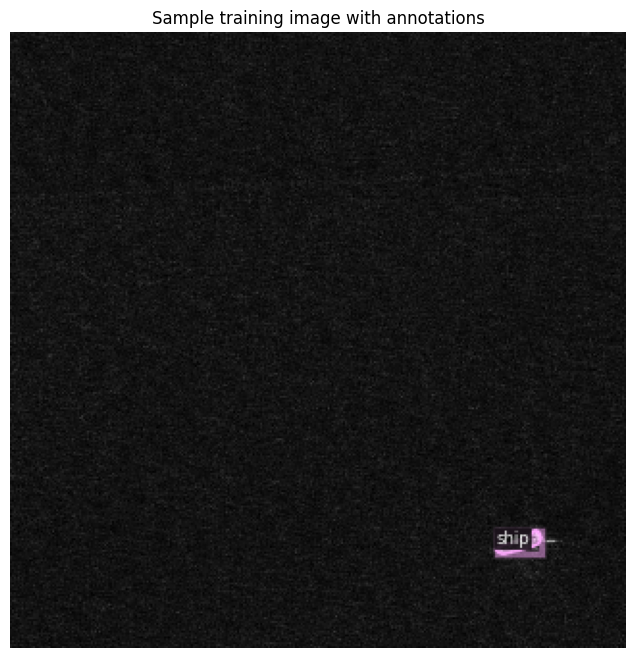

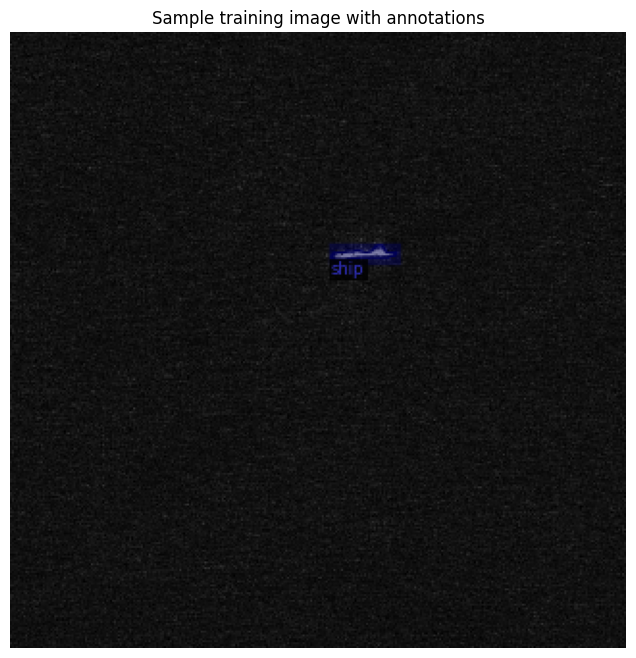

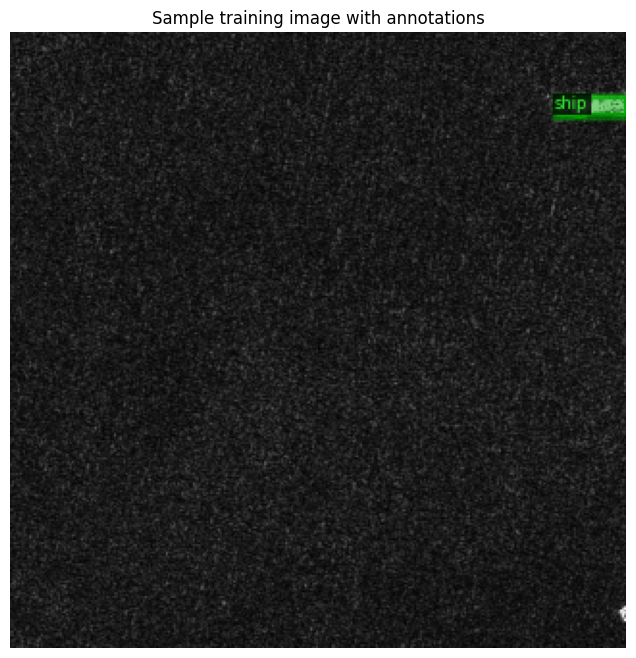

In [10]:
# Visualize the first few images
for sample in train_data[:3]:  
    img = cv2.imread(sample["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(sample)
    plt.figure(figsize=(12, 8))
    plt.imshow(out.get_image())
    plt.axis('off')
    plt.title("Sample training image with annotations")
    plt.show()

## Model Configuration Functions

In [11]:
def create_config(model_name, output_dir, max_iter=1200, batch_size=16, learning_rate=0.001):
    """
    Create a configuration for Faster R-CNN model.
    
    Args:
        model_name: "R_50" or "R_101" for ResNet-50 or ResNet-101
        output_dir: Directory to save model outputs
        max_iter: Number of training iterations
        batch_size: Images per batch
        learning_rate: Base learning rate
    
    Returns:
        cfg: Detectron2 config object
    """
    cfg = get_cfg()
    
    # Model architecture
    config_file = f"COCO-Detection/faster_rcnn_{model_name}_FPN_3x.yaml"
    cfg.merge_from_file(model_zoo.get_config_file(config_file))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_file)
    
    # Dataset
    cfg.DATASETS.TRAIN = ("sarscope_train",)
    cfg.DATASETS.TEST = ("sarscope_valid",)
    
    # Training parameters
    cfg.DATALOADER.NUM_WORKERS = 4
    cfg.SOLVER.IMS_PER_BATCH = batch_size
    cfg.SOLVER.BASE_LR = learning_rate
    cfg.SOLVER.MAX_ITER = max_iter
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only "ship" class
    
    # Output directory
    cfg.OUTPUT_DIR = output_dir
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    
    return cfg


def count_parameters(cfg):
    """Count and display model parameters."""
    model = build_model(cfg)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Breakdown by component
    print("\nParameters by component:")
    for name, module in model.named_children():
        params = sum(p.numel() for p in module.parameters())
        print(f"  {name}: {params:,}")
    
    return total_params, trainable_params

## Training Functions

In [12]:
class TrainerWithValidation(DefaultTrainer):
    """Custom trainer that runs validation during training."""
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(dataset_name, cfg, False, output_dir=cfg.OUTPUT_DIR)


def train_model(cfg, with_validation=True):
    """
    Train a Faster R-CNN model.
    
    Args:
        cfg: Detectron2 config object
        with_validation: Whether to run validation during training
    """
    # Clear old metrics if they exist
    metrics_file = os.path.join(cfg.OUTPUT_DIR, "metrics.json")
    if os.path.exists(metrics_file):
        os.remove(metrics_file)
        print("Cleared old metrics file")
    
    # Choose trainer
    if with_validation:
        cfg.TEST.EVAL_PERIOD = 200  # Evaluate every 200 iterations
        trainer = TrainerWithValidation(cfg)
    else:
        trainer = DefaultTrainer(cfg)
    
    trainer.resume_or_load(resume=False)
    trainer.train()
    
    print(f"\nTraining complete! Model saved to: {cfg.OUTPUT_DIR}")

## Evaluation Functions

In [33]:
def evaluate_model(cfg, dataset_name):
    """
    Evaluate a trained model on a dataset.
    
    Args:
        cfg: Detectron2 config object
        dataset_name: "sarscope_valid" or "sarscope_test"
    
    Returns:
        results: Evaluation metrics
    """
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    
    predictor = DefaultPredictor(cfg)
    
    evaluator = COCOEvaluator(dataset_name, cfg, False, output_dir=cfg.OUTPUT_DIR)
    data_loader = build_detection_test_loader(cfg, dataset_name)
    results = inference_on_dataset(predictor.model, data_loader, evaluator)
    
    return results


def visualize_predictions(cfg, dataset_name, num_samples=5):
    """Visualize predictions with larger images."""
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    
    predictor = DefaultPredictor(cfg)
    dataset = DatasetCatalog.get(dataset_name)
    metadata = MetadataCatalog.get(dataset_name)
    
    # Show images vertically (one per row) for bigger size
    fig, axes = plt.subplots(num_samples, 1, figsize=(15, 10 * num_samples))
    
    for i, sample in enumerate(dataset[:num_samples]):
        img = cv2.imread(sample["file_name"])
        outputs = predictor(img)
        
        v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=2.0)  # Increased scale
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        
        axes[i].imshow(out.get_image())
        axes[i].axis("off")
        axes[i].set_title(f"Image {i+1}", fontsize=16)
    
    plt.tight_layout()
    plt.show()

## Visualization Functions

In [14]:
def plot_training_loss(output_dir, title="Training Loss"):
    """
    Plot training loss from metrics file.
    
    Args:
        output_dir: Directory containing metrics.json
        title: Plot title
    """
    metrics_file = os.path.join(output_dir, "metrics.json")
    
    losses = []
    iterations = []
    
    with open(metrics_file, 'r') as f:
        for line in f:
            data = json.loads(line)
            if 'total_loss' in data:
                # Reset if new training run detected
                if iterations and data['iteration'] < iterations[-1]:
                    losses = []
                    iterations = []
                losses.append(data['total_loss'])
                iterations.append(data['iteration'])
    
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, losses)
    plt.xlabel('Iteration')
    plt.ylabel('Total Loss')
    plt.title(title)
    plt.grid(True)
    plt.show()


def compare_losses(output_dirs, labels):
    """
    Compare training losses from multiple models.
    
    Args:
        output_dirs: List of output directories
        labels: List of labels for each model
    """
    plt.figure(figsize=(12, 6))
    
    for output_dir, label in zip(output_dirs, labels):
        metrics_file = os.path.join(output_dir, "metrics.json")
        
        losses = []
        iterations = []
        
        with open(metrics_file, 'r') as f:
            for line in f:
                data = json.loads(line)
                if 'total_loss' in data:
                    if iterations and data['iteration'] < iterations[-1]:
                        losses = []
                        iterations = []
                    losses.append(data['total_loss'])
                    iterations.append(data['iteration'])
        
        plt.plot(iterations, losses, label=label)
    
    plt.xlabel('Iteration')
    plt.ylabel('Total Loss')
    plt.title('Training Loss Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()


def compare_predictions(configs, labels, dataset_name, num_samples=3):
    """
    Compare predictions from multiple models side by side.
    
    Args:
        configs: List of config objects
        labels: List of model labels
        dataset_name: Dataset to visualize
        num_samples: Number of samples to compare
    """
    dataset = DatasetCatalog.get(dataset_name)
    metadata = MetadataCatalog.get(dataset_name)
    
    # Create predictors
    predictors = []
    for cfg in configs:
        cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
        predictors.append(DefaultPredictor(cfg))
    
    num_models = len(configs)
    fig, axes = plt.subplots(num_samples, num_models, figsize=(6 * num_models, 6 * num_samples))
    
    for row, sample in enumerate(dataset[:num_samples]):
        img = cv2.imread(sample["file_name"])
        
        for col, (predictor, label) in enumerate(zip(predictors, labels)):
            outputs = predictor(img)
            
            v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.0)
            out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            
            ax = axes[row, col] if num_samples > 1 else axes[col]
            ax.imshow(out.get_image())
            ax.axis("off")
            if row == 0:
                ax.set_title(label)
    
    plt.tight_layout()
    plt.show()

## Train Model 1: Faster R-CNN with ResNet-50

In [15]:
# Create config for ResNet-50
cfg_r50 = create_config(
    model_name="R_50",
    output_dir="/kaggle/working/output_r50",
    max_iter=1200,
    batch_size=16,
    learning_rate=0.001
)

print(f"  Output dir: {cfg_r50.OUTPUT_DIR}")

  Output dir: /kaggle/working/output_r50


In [16]:
# Count parameters for ResNet-50
print("ResNet-50 Model Parameters:")
count_parameters(cfg_r50)

ResNet-50 Model Parameters:
Total parameters: 41,295,061
Trainable parameters: 41,072,661

Parameters by component:
  backbone: 26,799,296
  proposal_generator: 593,935
  roi_heads: 13,901,830


(41295061, 41072661)

In [ ]:
#import torch - used when GPU ran out in kaggle

#torch.cuda.empty_cache()

In [17]:
# Train ResNet-50 model
train_model(cfg_r50, with_validation=False)

[01/13 16:54:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:00, 194MB/s]                             
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_pr

[01/13 16:54:33 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/13 16:55:20 d2.utils.events]:  eta: 0:43:13  iter: 19  total_loss: 1.354  loss_cls: 0.5657  loss_box_reg: 0.4393  loss_rpn_cls: 0.3275  loss_rpn_loc: 0.05546    time: 2.1994  last_time: 2.2438  data_time: 0.1588  last_data_time: 0.1547   lr: 1.9981e-05  max_mem: 11032M


2026-01-13 16:55:23.299579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768323323.474878      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768323323.523337      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768323323.916472      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768323323.916521      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768323323.916524      55 computation_placer.cc:177] computation placer alr

[01/13 16:56:23 d2.utils.events]:  eta: 0:43:22  iter: 39  total_loss: 1.178  loss_cls: 0.4435  loss_box_reg: 0.4079  loss_rpn_cls: 0.1637  loss_rpn_loc: 0.04505    time: 2.2348  last_time: 2.3201  data_time: 0.1451  last_data_time: 0.1367   lr: 3.9961e-05  max_mem: 11033M
[01/13 16:57:10 d2.utils.events]:  eta: 0:43:08  iter: 59  total_loss: 0.9259  loss_cls: 0.3468  loss_box_reg: 0.4255  loss_rpn_cls: 0.1149  loss_rpn_loc: 0.03949    time: 2.2765  last_time: 2.4273  data_time: 0.1445  last_data_time: 0.1506   lr: 5.9941e-05  max_mem: 11033M
[01/13 16:57:57 d2.utils.events]:  eta: 0:43:06  iter: 79  total_loss: 0.8748  loss_cls: 0.3243  loss_box_reg: 0.4803  loss_rpn_cls: 0.0477  loss_rpn_loc: 0.03971    time: 2.2948  last_time: 2.3607  data_time: 0.1451  last_data_time: 0.1469   lr: 7.9921e-05  max_mem: 11033M
[01/13 16:58:44 d2.utils.events]:  eta: 0:42:41  iter: 99  total_loss: 0.8111  loss_cls: 0.2849  loss_box_reg: 0.4506  loss_rpn_cls: 0.04658  loss_rpn_loc: 0.03675    time: 2.3

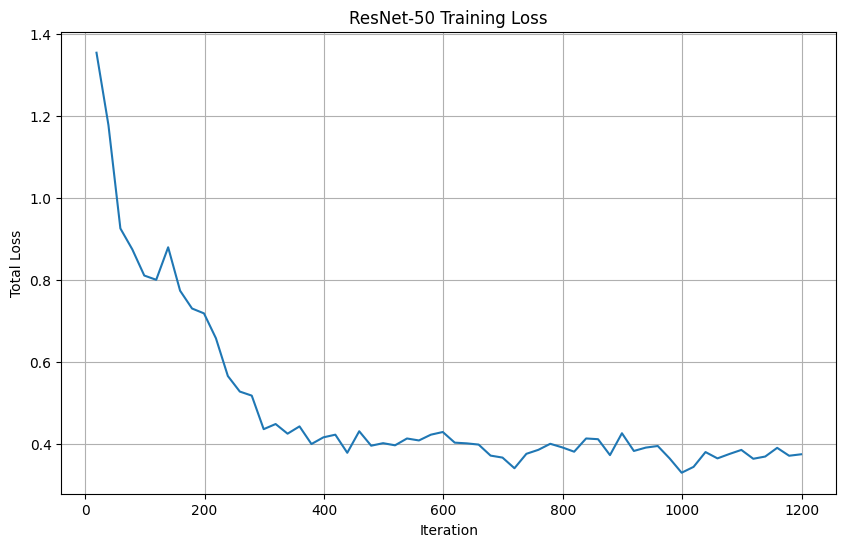

In [18]:
# Plot training loss for ResNet-50
plot_training_loss(cfg_r50.OUTPUT_DIR, title="ResNet-50 Training Loss")

**Analysis**

**Total Loss**
- Sharp drop from ~1.4 to ~0.8 as the model rapidly learns ship features from COCO pre-trained weights
- Loss stabilizes around 0.35-0.45 with minor fluctuations, indicating the model is fine-tuning.
- Unlike YOLO (Ultralytics) which computes validation after each epoch, Detectron2 uses iteration-based training with validation/testing performed separately after training completes.
- The slight downward trend at iteration 1200 suggests additional training could yield further improvements.

In [22]:
# Evaluate on validation set
print("=" * 50)
print("ResNet-50 Validation Results:")
print("=" * 50)
results_r50_valid = evaluate_model(cfg_r50, "sarscope_valid")


ResNet-50 Validation Results:
[01/13 17:47:18 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/output_r50/model_final.pth ...
WARNING [01/13 17:47:19 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[01/13 17:47:19 d2.data.datasets.coco]: Loaded 1346 images in COCO format from /kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/valid/_annotations.coco.json
[01/13 17:47:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/13 17:47:19 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/13 17:47:19 d2.data.common]: Serializing 1346 elements to byte tensors and concatenating them all ...
[01/13 17:47:19 d2.data.common]: Serialized dataset takes 5.00 MiB
[01/13 17:47:19 d2.e

In [23]:
# Evaluate on test set
print("=" * 50)
print("ResNet-50 Test Results:")
print("=" * 50)
results_r50_test = evaluate_model(cfg_r50, "sarscope_test")

ResNet-50 Test Results:
[01/13 17:49:36 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/output_r50/model_final.pth ...
WARNING [01/13 17:49:37 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[01/13 17:49:37 d2.data.datasets.coco]: Loaded 672 images in COCO format from /kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/test/_annotations.coco.json
[01/13 17:49:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/13 17:49:37 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/13 17:49:37 d2.data.common]: Serializing 672 elements to byte tensors and concatenating them all ...
[01/13 17:49:37 d2.data.common]: Serialized dataset takes 2.51 MiB
[01/13 17:49:37 d2.evaluation

## Plot on the VALIDATION SET

[01/13 18:05:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/output_r50/model_final.pth ...
[01/13 18:05:34 d2.data.datasets.coco]: Loaded 1346 images in COCO format from /kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/valid/_annotations.coco.json


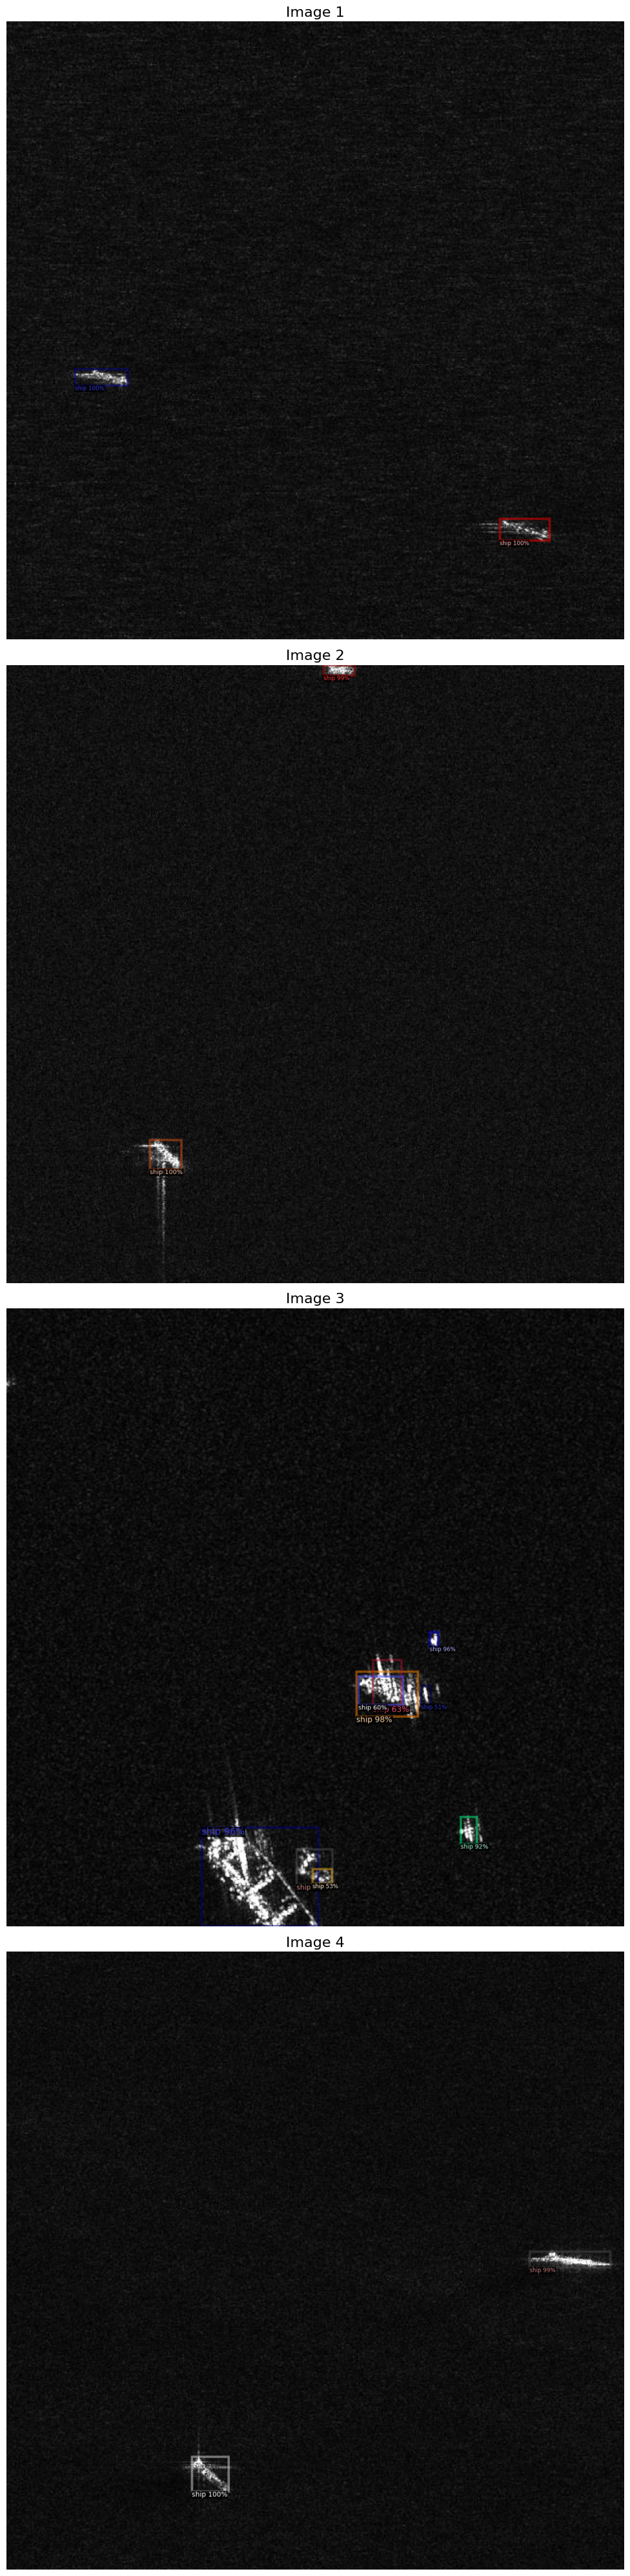

In [35]:
# plot prediction on the validation set

visualize_predictions(cfg_r50, "sarscope_valid", num_samples=4)

## Plot on the TEST SET

[01/13 18:04:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/output_r50/model_final.pth ...
[01/13 18:04:45 d2.data.datasets.coco]: Loaded 672 images in COCO format from /kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/test/_annotations.coco.json


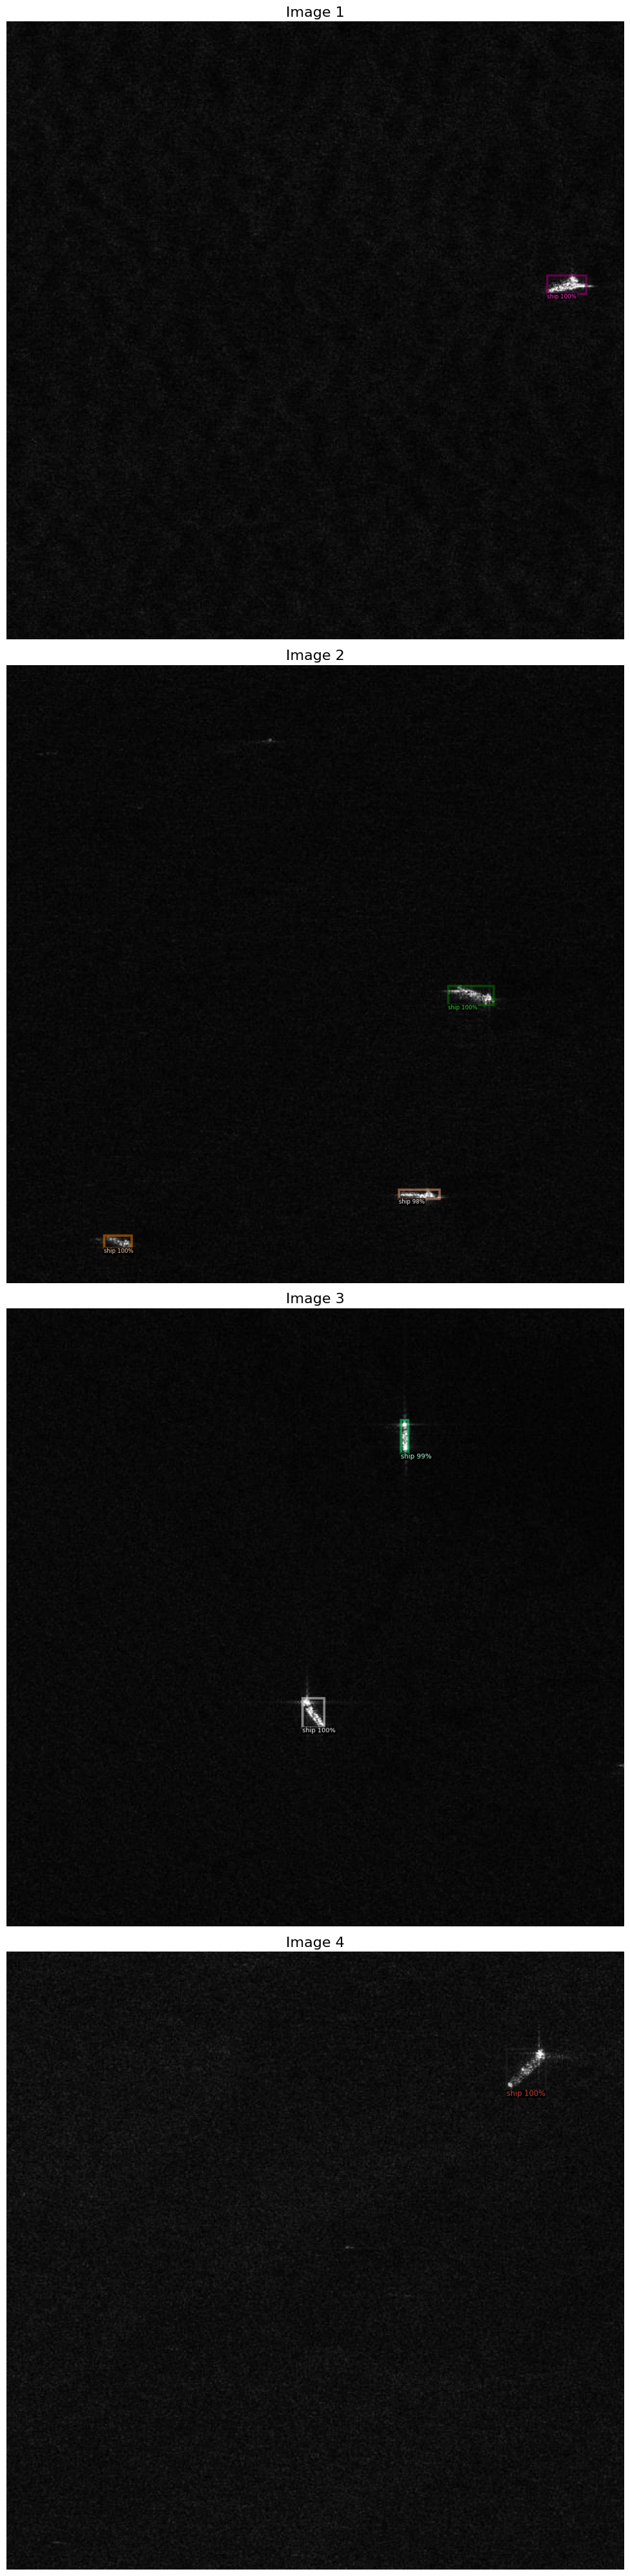

In [34]:
#plot prediction on the test set

visualize_predictions(cfg_r50, "sarscope_test", num_samples=4)

## Train Model 2: Faster R-CNN with ResNet-101

In [39]:
# Create config for ResNet-101
cfg_r101 = create_config(
    model_name="R_101",
    output_dir="/kaggle/working/output_r101",
    max_iter=1200,
    batch_size=16,
    learning_rate=0.001
)

print(f"  Output dir: {cfg_r101.OUTPUT_DIR}")

  Output dir: /kaggle/working/output_r101


In [40]:
# Count parameters for ResNet-101
print("ResNet-101 Model Parameters:")
count_parameters(cfg_r101)

ResNet-101 Model Parameters:
Total parameters: 60,234,965
Trainable parameters: 60,012,565

Parameters by component:
  backbone: 45,739,200
  proposal_generator: 593,935
  roi_heads: 13,901,830


(60234965, 60012565)

In [41]:
# Train ResNet-101 model
train_model(cfg_r101, with_validation=False)

[01/13 18:13:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:03, 64.5MB/s]                              
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_

[01/13 18:13:32 d2.engine.train_loop]: Starting training from iteration 0
[01/13 18:14:51 d2.utils.events]:  eta: 1:17:51  iter: 19  total_loss: 1.63  loss_cls: 0.7335  loss_box_reg: 0.531  loss_rpn_cls: 0.3374  loss_rpn_loc: 0.06236    time: 3.9476  last_time: 3.9374  data_time: 0.1611  last_data_time: 0.1524   lr: 1.9981e-05  max_mem: 12981M
ERROR [01/13 18:15:55 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py", line 152, in train
    self.run_step()
  File "/usr/local/lib/python3.12/dist-packages/detectron2/engine/defaults.py", line 530, in run_step
    self._trainer.run_step()
  File "/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py", line 319, in run_step
    losses.backward()
  File "/usr/local/lib/python3.12/dist-packages/torch/_tensor.py", line 647, in backward
    torch.autograd.backward(
  File "/usr/local/lib/python3.12/dist-packages/tor

OutOfMemoryError: CUDA out of memory. Tried to allocate 626.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 574.19 MiB is free. Process 3132 has 14.18 GiB memory in use. Of the allocated memory 12.06 GiB is allocated by PyTorch, and 1.98 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## KAGGLE RAN OUT OF MEMORY SO WE COULDN'T FINISH Training ON RESNET-101